In [45]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import box
from geopy.distance import geodesic
import time
from tqdm import tqdm

In [46]:
# Load the filtered light intensity dataset and the Ookla internet speed dataset
filtered_light_intensity_original = pd.read_parquet('filtered_indonesia_light_intensity.parquet')
indonesia_internet_speed_original = pd.read_parquet('Indonesia_Internet_Speed.parquet')

filtered_light_intensity = filtered_light_intensity_original.copy()
indonesia_internet_speed = indonesia_internet_speed_original.copy()

In [47]:
print("Shape:", filtered_light_intensity.shape)
print("Columns:", filtered_light_intensity.columns.tolist())
print("Missing Values:\n", filtered_light_intensity.isnull().sum())
print("Data Types:\n", filtered_light_intensity.dtypes)
print("Sample Rows:\n", filtered_light_intensity.head())


Shape: (4422070, 4)
Columns: ['latitude', 'longitude', 'area_type', 'log_light_intensity']
Missing Values:
 latitude               0
longitude              0
area_type              0
log_light_intensity    0
dtype: int64
Data Types:
 latitude                float64
longitude               float64
area_type              category
log_light_intensity     float64
dtype: object
Sample Rows:
    latitude  longitude   area_type  log_light_intensity
0       0.0  98.216667    emerging             0.067659
1       0.0  98.220834  developing             0.122218
2       0.0  98.225000  developing             0.104360
3       0.0  98.229167    emerging             0.029559
4       0.0  98.245834    emerging             0.048790


In [48]:
print("Shape:", indonesia_internet_speed.shape)
print("Columns:", indonesia_internet_speed.columns.tolist())
print("Missing Values:\n", indonesia_internet_speed.isnull().sum())
print("Data Types:\n", indonesia_internet_speed.dtypes)
print("Sample Rows:\n", indonesia_internet_speed.head())


Shape: (26585, 12)
Columns: ['quadkey', 'tile', 'tile_x', 'tile_y', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'avg_lat_down_ms', 'avg_lat_up_ms', 'tests', 'devices', 'geometry']
Missing Values:
 quadkey                0
tile                   0
tile_x                 0
tile_y                 0
avg_d_kbps             0
avg_u_kbps             0
avg_lat_ms             0
avg_lat_down_ms    26585
avg_lat_up_ms      26585
tests                  0
devices                0
geometry               0
dtype: int64
Data Types:
 quadkey             object
tile                object
tile_x             float64
tile_y             float64
avg_d_kbps           int64
avg_u_kbps           int64
avg_lat_ms           int64
avg_lat_down_ms    float64
avg_lat_up_ms      float64
tests                int64
devices              int64
geometry            object
dtype: object
Sample Rows:
                   quadkey                                               tile  \
4344504  3100011100231210  POLYGON((99.98657226

In [49]:
import pandas as pd
import numpy as np

# Load dataset
data = filtered_light_intensity.copy()

# Step 1: Aggregate mean radiance for each location
grouped_data = data.groupby(['latitude', 'longitude']).agg(
    mean_radiance=('log_light_intensity', 'mean'),
    count=('log_light_intensity', 'count')
).reset_index()

# Step 2: Define thresholds for classification
mean_radiance_high_threshold = np.percentile(grouped_data['mean_radiance'], 80)  # Top 20% for established
mean_radiance_low_threshold = np.percentile(grouped_data['mean_radiance'], 20)  # Bottom 20% for "other"

# Step 3: Classify regions
grouped_data['area_classification'] = np.where(
    grouped_data['mean_radiance'] > mean_radiance_high_threshold, 'established',
    np.where(
        grouped_data['mean_radiance'] <= mean_radiance_low_threshold, 'other', 'emerging'
    )
)

# Step 4: Output the classification results
print(grouped_data.head())

# Optional: Display thresholds for reference
print("Mean Radiance High Threshold (80th Percentile):", mean_radiance_high_threshold)
print("Mean Radiance Low Threshold (20th Percentile):", mean_radiance_low_threshold)

# Count classifications for verification
print(grouped_data['area_classification'].value_counts())

    latitude   longitude  mean_radiance  count area_classification
0 -11.004167  122.870834       0.019803      1               other
1 -11.004167  122.875001       0.009950      1               other
2 -11.004167  122.879167       0.039221      1               other
3 -11.004167  122.883334       0.029559      1               other
4 -11.000000  122.866667       0.029559      1               other
Mean Radiance High Threshold (80th Percentile): 0.2468600779315258
Mean Radiance Low Threshold (20th Percentile): 0.048790164169432
area_classification
emerging       2457565
other          1082825
established     881680
Name: count, dtype: int64


c:\Users\nasrr\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


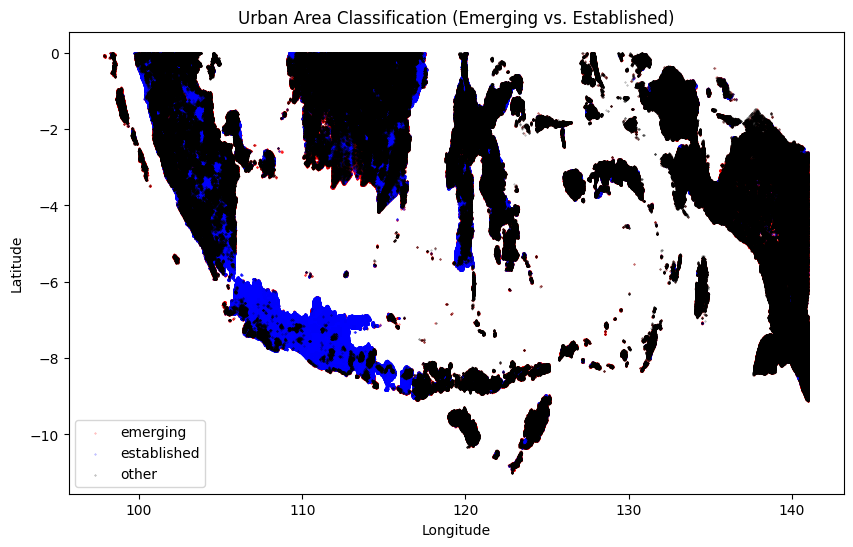

In [50]:
# Plot classified areas
plt.figure(figsize=(10, 6))
for classification, color in zip(['emerging', 'established', 'other'], ['red', 'blue', 'black']):
    subset = grouped_data[grouped_data['area_classification'] == classification]
    plt.scatter(subset['longitude'], subset['latitude'], label=classification, c=color, alpha=0.5, s=0.1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Urban Area Classification (Emerging vs. Established)')
plt.legend()
plt.show()

In [ ]:
# Step 1: Scale internet speed tile coordinates to longitude and latitude
tile_x_min, tile_x_max = indonesia_internet_speed['tile_x'].min(), indonesia_internet_speed['tile_x'].max()
tile_y_min, tile_y_max = indonesia_internet_speed['tile_y'].min(), indonesia_internet_speed['tile_y'].max()

longitude_min, longitude_max = filtered_light_intensity['longitude'].min(), filtered_light_intensity['longitude'].max()
latitude_min, latitude_max = filtered_light_intensity['latitude'].min(), filtered_light_intensity['latitude'].max()

# Scaling factors
tile_to_lon_factor = (longitude_max - longitude_min) / (tile_x_max - tile_x_min)
tile_to_lat_factor = (latitude_max - latitude_min) / (tile_y_max - tile_y_min)

print(tile_to_lon_factor, tile_to_lat_factor)

# Convert tile_x and tile_y to longitude and latitude
indonesia_internet_speed['longitude'] = (
    (indonesia_internet_speed['tile_x'] - tile_x_min) * tile_to_lon_factor + longitude_min
)
indonesia_internet_speed['latitude'] = (
    (indonesia_internet_speed['tile_y'] - tile_y_min) * tile_to_lat_factor + latitude_min
)

# Step 2: Convert to GeoDataFrames
gdf_light_intensity = gpd.GeoDataFrame(
    filtered_light_intensity,
    geometry=gpd.points_from_xy(filtered_light_intensity['longitude'], filtered_light_intensity['latitude']),
    crs="EPSG:4326"
)

# Create internet speed GeoDataFrame
indonesia_internet_speed['geometry'] = indonesia_internet_speed.apply(
    lambda row: Point(row['longitude'], row['latitude']), axis=1
)
gdf_internet_speed = gpd.GeoDataFrame(indonesia_internet_speed, geometry='geometry', crs="EPSG:4326")

# Step 3: Reproject both GeoDataFrames to a projected CRS for accurate distance calculation
gdf_light_intensity = gdf_light_intensity.to_crs("EPSG:3395")  # Reproject to projected CRS (meters)
gdf_internet_speed = gdf_internet_speed.to_crs("EPSG:3395")  # Reproject to projected CRS (meters)

# Step 4: Build spatial index for fast nearest-neighbor search
gdf_light_intensity = gdf_light_intensity.reset_index(drop=True)
gdf_internet_speed = gdf_internet_speed.reset_index(drop=True)


1.0505931175358527 1.0223880216571282


In [ ]:

# Step 1: Efficient nearest neighbor lookup using spatial index
def find_nearest_area_type(row, target_gdf, spatial_index, max_distance_km=10):
    # Get the bounding box of the current point (row)
    minx, miny, maxx, maxy = row['geometry'].buffer(max_distance_km * 1000).bounds
    
    # Query the spatial index for candidate points
    possible_matches_index = list(spatial_index.intersection((minx, miny, maxx, maxy)))
    
    if not possible_matches_index:
        return None  # No matches in the neighborhood
    
    # Calculate distances for each candidate and return the closest one
    nearest_point = None
    min_distance = float('inf')
    
    for idx in possible_matches_index:
        candidate = target_gdf.iloc[idx]
        distance = row['geometry'].distance(candidate['geometry'])  # Distance in meters
        
        if distance < min_distance:
            nearest_point = candidate
            min_distance = distance
    
    # Convert distance to kilometers for comparison
    distance_km = min_distance / 1000
    
    if nearest_point and distance_km <= max_distance_km:
        return nearest_point['area_type']
    return None  # No match found within threshold


# Step 2: Process the data in chunks with progress tracking
def map_area_types_in_chunks(gdf_internet_speed, gdf_light_intensity, chunk_size=1000, max_distance_km=10):
    # Spatial index for faster lookup
    spatial_index = gdf_light_intensity.sindex
    
    # List to store results
    area_types = []
    
    # Start progress bar
    pbar = tqdm(total=gdf_internet_speed.shape[0], desc="Mapping Area Types")
    
    # Split data into chunks
    for start_idx in range(0, gdf_internet_speed.shape[0], chunk_size):
        # End index for the chunk
        end_idx = min(start_idx + chunk_size, gdf_internet_speed.shape[0])
        
        # Process each chunk
        chunk = gdf_internet_speed.iloc[start_idx:end_idx]
        
        # Start time for the chunk
        chunk_start_time = time.time()
        
        # Apply the nearest neighbor lookup for each row in the chunk
        chunk['area_type'] = chunk.apply(
            lambda row: find_nearest_area_type(row, gdf_light_intensity, spatial_index, max_distance_km),
            axis=1
        )
        
        # Append the chunk results
        area_types.extend(chunk['area_type'].tolist())
        
        # Update progress bar
        pbar.update(len(chunk))
        
        # Print time for each chunk processed
        chunk_time = time.time() - chunk_start_time
        print(f"Processed {len(chunk)} rows in {chunk_time:.2f} seconds.")
        
    pbar.close()
    
    # Assign the area types to the full DataFrame
    gdf_internet_speed['area_type'] = area_types
    return gdf_internet_speed


# Step 3: Aggregate metrics by area type
def aggregate_metrics_by_area_type(gdf_internet_speed):
    aggregated_metrics = gdf_internet_speed.groupby('area_type').agg(
        avg_download_speed=('avg_d_kbps', 'mean'),
        avg_upload_speed=('avg_u_kbps', 'mean'),
        avg_latency=('avg_lat_ms', 'mean'),
        count=('quadkey', 'count')
    ).reset_index()
    
    return aggregated_metrics


# Step 4: Compute growth rates (relative differences between established and emerging)
def compute_growth_rates(aggregated_metrics):
    growth_rates = {}
    if 'established' in aggregated_metrics['area_type'].values and 'emerging' in aggregated_metrics['area_type'].values:
        established_metrics = aggregated_metrics.loc[aggregated_metrics['area_type'] == 'established']
        emerging_metrics = aggregated_metrics.loc[aggregated_metrics['area_type'] == 'emerging']
        
        growth_rates = {
            'download_growth_rate': (established_metrics['avg_download_speed'].values[0] - emerging_metrics['avg_download_speed'].values[0])
                                   / emerging_metrics['avg_download_speed'].values[0] * 100,
            'upload_growth_rate': (established_metrics['avg_upload_speed'].values[0] - emerging_metrics['avg_upload_speed'].values[0])
                                   / emerging_metrics['avg_upload_speed'].values[0] * 100,
            'latency_growth_rate': (emerging_metrics['avg_latency'].values[0] - established_metrics['avg_latency'].values[0])
                                   / emerging_metrics['avg_latency'].values[0] * 100  # Latency is better when lower
        }
    
    return growth_rates


# Step 5: Output results
def print_results(aggregated_metrics, growth_rates):
    print("Aggregated Metrics by Area Type:")
    print(aggregated_metrics)
    print("\nGrowth Rates (Emerging vs. Established):")
    print(growth_rates)


# Final execution with progress bar, chunk-based processing, and time tracking
start_time = time.time()
gdf_internet_speed = map_area_types_in_chunks(gdf_internet_speed, gdf_light_intensity)
aggregated_metrics = aggregate_metrics_by_area_type(gdf_internet_speed)
growth_rates = compute_growth_rates(aggregated_metrics)
print_results(aggregated_metrics, growth_rates)

# Print total execution time
total_time = time.time() - start_time
print(f"Total execution time: {total_time:.2f} seconds.")
